In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 检查 GPU 是否可用
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available


### Data Preparation

#### Vitual Data

In [16]:
'''
生成天气数据： 使用正弦函数模拟温度和湿度的周期性变化，并添加随机噪声。使用随机数生成风速数据。
添加天气数据到 DataFrame： 将生成的天气数据添加到 load_data 中。
生成日历数据： 使用 time_index.weekday 获取每个时间点对应的星期几，然后判断是否为周末，并假设没有节假日。
添加日历数据到 DataFrame： 将生成的日历数据添加到 load_data 中。
'''


#创建模拟数据集
np.random.seed(42)  # 设置随机种子，保证结果可复现

# 时间维度：一周7天，每天96个时间点（每15分钟一个）
time_index = pd.date_range(start='2024-01-01', end='2024-07-31 23:45', freq='15min')

# 空间维度：假设有3个变电站
# substations = ['A', 'B', 'C']




load_data = pd.DataFrame(index=time_index)
# 添加日历数据
load_data['Weekday'] = time_index.weekday  # 0: Monday, 1: Tuesday, ..., 6: Sunday
load_data['IsWeekend'] = load_data['Weekday'].isin([5, 6]).astype(int)  # 1: Weekend, 0: Weekday

# 添加天气数据
temperature = 20 + 10 * np.sin(2 * np.pi * (np.arange(len(time_index))-32) / 96) + np.random.rand(len(time_index)) * 5
humidity = 50 + 20 * np.sin(2 * np.pi * np.arange(len(time_index)) / 96) + np.random.rand(len(time_index)) * 10
wind_speed = 5 + 3 * np.random.rand(len(time_index))

load_data['Temperature'] = temperature
load_data['Humidity'] = humidity
load_data['WindSpeed'] = wind_speed
#load_data['IsHoliday'] = 0  # 假设没有节假日

# 模拟负荷数据：
# - 基本负荷：每个变电站有一个基本负荷值，在一天内波动
# - 随机噪声：添加随机噪声，模拟实际负荷的波动
#base_loads = {'A': 100, 'B': 150, 'C': 200}

base_loads =  200 + np.random.uniform(0.9,1.1) * 50 * np.abs(load_data['Temperature']-20)/15   # 每天的波动范围为0-50, 与温度有关
work_hours_variations = np.array([max(0,np.sin(np.pi * (i % 96-32) / 32))*200 for i in range(len(time_index))])*np.random.uniform(0.9,1.1,len(time_index)) *(1+np.abs((load_data['Humidity']-50)/240)) # 工作时间段的波动范围为0-100
noise = np.random.rand(len(time_index)) * 50  # 随机噪声
load_data['base_loads'] = base_loads + noise
load_data["work_hours"] = work_hours_variations
load_data["real_load"] = load_data["work_hours"] * (1-load_data["IsWeekend"])+ load_data['base_loads']


print(load_data.head())


                     Weekday  IsWeekend  Temperature   Humidity  WindSpeed  \
2024-01-01 00:00:00        0          0    13.212447  55.088214   7.952458   
2024-01-01 00:15:00        0          0    15.784844  60.527021   7.907493   
2024-01-01 00:30:00        0          0    14.421174  61.206200   7.741282   
2024-01-01 00:45:00        0          0    13.523991  63.589341   6.305941   
2024-01-01 01:00:00        0          0    11.120835  61.681172   5.500009   

                     base_loads  work_hours   real_load  
2024-01-01 00:00:00  244.721562         0.0  244.721562  
2024-01-01 00:15:00  225.573837         0.0  225.573837  
2024-01-01 00:30:00  265.233671         0.0  265.233671  
2024-01-01 00:45:00  262.074133         0.0  262.074133  
2024-01-01 01:00:00  277.203636         0.0  277.203636  


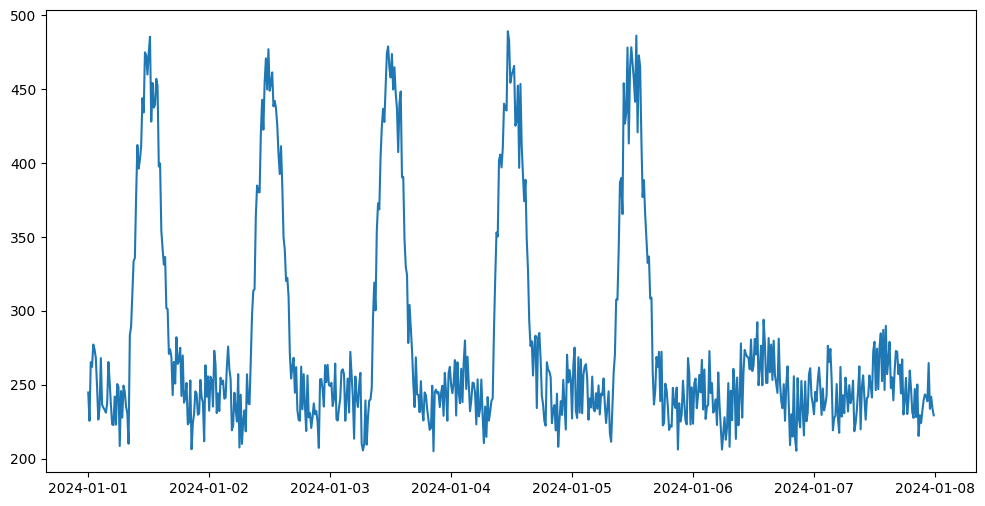

In [17]:
plt_data = load_data[:96*7]
fig = plt.figure(figsize=(12, 6))
plt.plot(plt_data.index, plt_data['real_load'], label='Real Load')

#### Real Data

In [5]:
load_data = pd.read_csv(r'C:\Users\Georg\Desktop\TTRS\2-EMS\research\Forecasting\Data\105.csv', index_col='time', parse_dates=True)

In [6]:
load_data.drop(index=load_data[load_data['values']>250].index, inplace=True)

KeyError: 'values'

In [4]:
# # 数据预处理
scaler = MinMaxScaler()  # 使用 MinMaxScaler 进行特征缩放
# load_data[['real_load', 'Temperature', 'Humidity']] = scaler.fit_transform(load_data[['real_load', 'Temperature', 'Humidity']])
load_data[['values']] = scaler.fit_transform(load_data[['values']])

# # 缺失值处理（如果需要）
load_data.fillna(method='ffill', inplace=True)  # 使用前一个值填充缺失值

# # 特征选择
# input_cols = ['real_load','IsWeekend','Temperature','Humidity',]
# input_cols = ['values','weekday','season']
input_cols = ['values']



# 创建输入输出序列
def create_sequences(data, seq_length, target_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - target_length):
        x = data[i:(i + seq_length)].values
        y = data['values'][(i + seq_length):(i + seq_length + target_length)].values
        # y = data.loc[(i + seq_length):(i + seq_length + target_length), 'real_load'].values
        if i == 0:
            print(x.shape, y.shape)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 288*5   # 使用前七天的数据作为输入
target_length = 288  # 预测未来一天的负荷

X, y = create_sequences(load_data[input_cols], seq_length, target_length)
print(X.shape, y.shape)
# 划分训练集和验证集
train_size = int(0.8 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# 构建 DataLoader
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

for i, batch in enumerate(val_loader):
    if i == 0:
        inputs, labels = batch
        print(labels[0])
        print(inputs[0])
        print(inputs.shape, labels.shape)


NameError: name 'load_data' is not defined

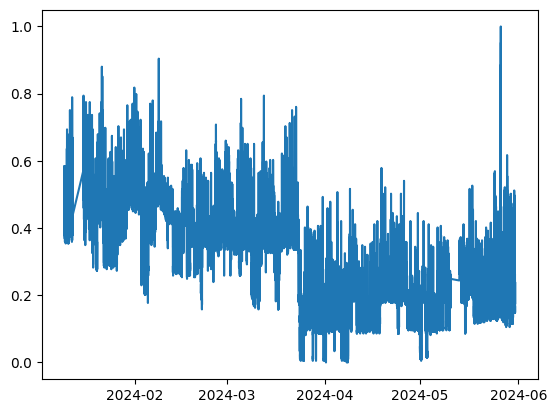

In [6]:
plt.plot(load_data['values'])

### Model Constrcution

In [7]:
class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()

    def forward(self, output, target):
        output = output.float()
        target = target.float()
        mape = torch.abs((output - target) / (target+1e-6))
        return torch.mean(mape)

In [8]:

class ConvBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3, padding=1, pool_size=2):
        super().__init__()
        self.conv = nn.Conv1d(input_dim, hidden_dim, kernel_size, padding=padding)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(pool_size)

    def forward(self, x):
        return self.pool(self.relu(self.conv(x)))  # More concise forward pass

In [9]:

class ForecastingEncoder(nn.Module):
    """The RNN encoder for sequence-to-sequence learning.

    Defined in :numref:`sec_seq2seq`"""
    def __init__(self, num_features, num_hiddens, num_layers,
                 bidirectional = False, dropout=0):
        super().__init__()
        self.rnn = nn.GRU(input_size = num_features, hidden_size = num_hiddens, num_layers = num_layers,
                      batch_first=False, bidirectional = bidirectional, dropout=dropout)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps, num_features)
        outputs, state = self.rnn(X)
        # print('inner outputs shape',outputs.shape)
        # print('inner state shape',state.shape)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

In [10]:

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1, encoder_bi = True):
        super().__init__()
        num_encoder_dire = 2 if encoder_bi else 1
        self.W_q = nn.Linear(hidden_dim, hidden_dim*num_encoder_dire, bias=False)  # No bias needed for the query
        self.W_k = nn.Linear(hidden_dim*num_encoder_dire, hidden_dim*num_encoder_dire, bias=False)
        self.W_v = nn.Linear(hidden_dim*num_encoder_dire, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, keys, values,):
        # query的形状：(batch_size，查询的个数，num_hidden)
        # keys的形状：(batch_size，“键－值”对的个数，num_hiddens*2 if bi-directional else num_hiddens)
        queries, keys = self.W_q(query), self.W_k(keys)
        # print('inner queries.shape',queries.shape)
        # print('inner keys.shape',keys.shape)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        # features的形状：(batch_size，查询的个数，“键-值”对的个数，num_hiddens)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        # print('inner features.shape',features.shape)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.W_v(features).squeeze(-1)
        self.attention_weights = F.softmax(scores,dim=-1)
        # print('inner self.attention_weights shape',self.attention_weights.shape)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        # print('inner values shape',values.shape)
        # context的形状：(batch_size，查询的个数，值的维度)
        context = torch.bmm(self.dropout(self.attention_weights), values) 
        # print('inner context.shape',context.shape)

        return context



In [12]:
class ForecastingEncoderDecoder(nn.Module):
    def __init__(self, num_features, hidden_dims, num_hiddens, num_layers, output_dim, num_steps, batch_size,
                 encoder_bi = False,dropout=0):
        super().__init__()
        self.conv_blocks = nn.ModuleList([
            ConvBlock(num_features if i == 0 else hidden_dims[i - 1], hidden_dims[i]) 
            for i in range(len(hidden_dims))])
        self.encoder = ForecastingEncoder(hidden_dims[-1], num_hiddens, num_layers, dropout=0.1)
        self.attention = AdditiveAttention(num_hiddens, dropout,encoder_bi=encoder_bi)
        self.decoder = nn.GRU(
            hidden_dims[-1] + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense1 = nn.Linear(num_hiddens, 1)
        self.dense2 = nn.LazyLinear(output_dim)
        self.activ = nn.Sigmoid()
        self.batch_size = batch_size
        self.output_dim = output_dim

    def init_state(self, enc_outputs):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        output, hidden_state = enc_outputs
        return (output.permute(1, 0, 2), hidden_state)

    def forward(self, X):
        for block in self.conv_blocks:
            X = block(X)
            print(f"After {block.__class__.__name__}:", X.shape)
        # Encoder
        # Shape of the X: (num_steps, batch_size, hidden_dim[-1])
        X = X.permute(2, 0, 1)  # [batch, hidden_dim[-1], seq_len] -> [ seq_len, batch_size, hidden_dim[-1]]
        # print('X.shape',X.shape)

        # Shape of enc_out: (num_steps, batch_size, num_hiddens), (num_layers, batch_size, num_hiddens)
        enc_out= self.encoder(X)
        # print('encoder output shape',enc_out[0].shape, enc_out[1].shape)

        # Shape of state: (batch_size, num_steps, num_hiddens), (num_layers, batch_size, num_hiddens)
        state = self.init_state(enc_out)
        # print('initial state.shape',state[0].shape, state[1].shape)

        # Shape of enc_output: (batch_size, num_steps, num_hiddens)
        # Shape of hidden sttate: (num_layers, batch_size, num_hiddens)
        enc_output, hidden_state = state
        # print('enc_output.shape',enc_output.shape)

        
        # X = X.permute(1, 0, 2)
        # print('X.shape',X.shape)
        outputs, self._attention_weights = [], []
        for x in X:
            # print('x.shape',x.shape)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # print('query.shape',query.shape)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_output, enc_output)
            # Concatenate on tshe feature dimension
            # print('context.shape',context.shape)
   
            # print(torch.unsqueeze(x, dim=1).shape)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # print('renewed x shape',x.shape)
            # Reshape x as (1, batch_size, num_features + num_hiddens)
            out, hidden_state = self.decoder(x.permute(1, 0, 2), hidden_state)
            # print('out.shape',out.shape)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # outputs shape: (num_steps, batch_size, output_dim)
        outputs = torch.cat(outputs, dim=0)
        outputs = self.dense1(outputs).permute(1, 0, 2)
        # print('after dense1 outputs shape',outputs.shape)
        outputs = self.activ(self.dense2(outputs.squeeze(-1)))
        # print('Output has gradiants?', outputs.requires_grad)
        # # Shape of outputs: (batch_size, num_steps, output_dim)
        # print('outputs.shape',outputs.shape)
        return outputs, [enc_output, hidden_state]
    


    @property
    def attention_weights(self):
        return self._attention_weights
    
    def predict_steps(self, X, num_steps=288):
        predictions = torch.zeros((self.batch_size,self.output_dim)).to(device)
        for step in range(num_steps):
            # print('X.shape',X.shape)
            step_prediction,_ = self.forward(X)
            # print('step_prediction.shape',step_prediction.shape)
            X = torch.cat((X, step_prediction.unsqueeze(-1)), dim=-1)
            # print('X.shape',X.shape)
            X = X[:,:,1:]
            # print('X.shape',X.shape)
            predictions = torch.cat((predictions, step_prediction), dim=1)
        predictions = predictions[:,1:]

        return predictions

    @property
    def attention_weights(self):
        return self._attention_weights

### Model Training

In [14]:
num_features = 1  # 输入特征维度
hidden_dims = [16,32,64,128]  # 隐藏层维度
num_hiddens =  256 # GRU隐藏层维度
num_layers = 3  # GRU 层数
output_dim = 96  # 输出维度（与输入维度相同）
batch_size = 128
seq_length = 96*7

model_example = ForecastingEncoderDecoder(num_features, hidden_dims, num_hiddens, num_layers, output_dim, seq_length, batch_size, dropout=0).to(device)

data = torch.randn(batch_size, seq_length, num_features).to(device)
target = torch.randn(batch_size, output_dim).to(device)
data = data.permute(0, 2, 1)
output, state = model_example(data)  # teacher_forcing_ratio 可调
print(output.shape, target.shape)
predictions = model_example.predict_steps(data, num_steps=4)
print('predictions.shape',predictions.shape)



After ConvBlock: torch.Size([128, 16, 336])
After ConvBlock: torch.Size([128, 32, 168])
After ConvBlock: torch.Size([128, 64, 84])
After ConvBlock: torch.Size([128, 128, 42])
torch.Size([128, 96]) torch.Size([128, 96])
After ConvBlock: torch.Size([128, 16, 336])
After ConvBlock: torch.Size([128, 32, 168])
After ConvBlock: torch.Size([128, 64, 84])
After ConvBlock: torch.Size([128, 128, 42])


RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 1 but got size 96 for tensor number 1 in the list.

In [11]:
criterion = nn.MSELoss()  # 使用均方误差作为损失函数
# criterion = nn.L1Loss()  # 使用平均绝对误差作为损失函数
# criterion = MAPELoss()  # 使用平均绝对百分比误差作为损失函数


num_features = 1  # 输入特征维度
hidden_dims = [16,32,64]  # 隐藏层维度
num_hiddens =  256 # GRU隐藏层维度
num_layers = 3  # GRU 层数
output_dim = 288  # 输出维度
batch_size = 128
seq_length = 288*5

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=24, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=24, pin_memory=True)

model = ForecastingEncoderDecoder(num_features, hidden_dims, num_hiddens, num_layers, output_dim, seq_length, batch_size, dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)  # 使用 Adam 优化器

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        data = data.permute(0, 2, 1)
        target = target.to(device)
        # target = target.unsqueeze(-1)
        # print('data.shape',data.shape)
        # print('target.shape',target.shape)

        optimizer.zero_grad()
        output, state = model(data) 
        # output = output.permute(1, 0, 2)
        # print('Output shape:', output.shape)
        # print('Target shape:', target.shape)
        # if batch_idx == len(train_loader)-1:
        #     print(f"Output at final batch:", output)
        loss = criterion(output, target)
        loss.backward()

        # if batch_idx == len(train_loader)-1:
        #     for name, param in model.named_parameters():
        #         print(f"Name: {name}, Shape: {param.shape}, Gradient Required: {param.requires_grad}",'Gradiant is not None:', param.grad != None)
        #     print(f" Output Gradient at {batch_idx} batch:", output.grad)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

    # 在验证集上评估模型
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for data, target in val_loader:
            data = data.to(device)
            data = data.permute(0, 2, 1)
            target = target.to(device)
            # target = target.unsqueeze(-1)

            output, state = model(data) 
            loss = criterion(output, target)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")

Epoch 1/100, Loss: 0.1262
Validation Loss: 0.0470
Epoch 2/100, Loss: 0.1272
Validation Loss: 0.0470
Epoch 3/100, Loss: 0.1272
Validation Loss: 0.0470
Epoch 4/100, Loss: 0.1272
Validation Loss: 0.0470
Epoch 5/100, Loss: 0.1272
Validation Loss: 0.0470
Epoch 6/100, Loss: 0.1272
Validation Loss: 0.0470
Epoch 7/100, Loss: 0.1272
Validation Loss: 0.0470


KeyboardInterrupt: 

In [12]:
# 在验证集上进行预测
model.eval()
predictions = []
actual_values = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
         # print(inputs.shape, labels.shape)
        inputs = inputs.to(device)
        inputs = inputs.permute(0, 2, 1)
        outputs, _ = model(inputs)
        labels = labels.to(device)
        loss = MAPELoss()(outputs, labels)

        predictions.append(outputs.cpu().numpy())
        actual_values.append(labels.cpu().numpy())
        # if i == 0 or i ==5 :
        #     print(outputs.shape, labels.shape)
        #     print(f"Predictions shape: {np.array(predictions).shape}")
        #     print(f"Actual values shape: {np.array(actual_values).shape}")
        loss += loss.item()
    
    loss /= len(val_loader)
    print(f"Validation MAPE Loss: {loss:.4f}")

predictions = np.concatenate(predictions)
actual_values = np.concatenate(actual_values)
# print(f"Predictions shape: {predictions.shape}")
# print(f"Actual values shape: {actual_values.shape}")


Validation MAPE Loss: 0.0339


In [ ]:
for name, param in model.named_parameters():
        print(f"Name: {name}, Shape: {param.shape}, Gradient Required: {param.requires_grad}",'Gradiant is not None:', param.grad != None)

#### Multiple Step Prediction Visualization

In [17]:
predictions.shape

(7450, 288)

In [14]:
predictions[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
plot_predictions = []
plot_actual = []
predic_steps =288

for i in range(len(predictions)//predic_steps):
    plot_predictions.append(predictions[i*predic_steps])
    plot_actual.append(actual_values[i*predic_steps])

plot_predictions = np.array(plot_predictions)
plot_actual = np.array(plot_actual)
# 可视化预测值和实际值
plt.figure(figsize=(12, 6))
plt.plot(plot_actual.flatten()[:predic_steps*2], label='Actual')
plt.plot(plot_predictions.flatten()[:predic_steps*2], label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Load')
plt.legend()
plt.title('Actual vs. Predicted Load on Validation Set')
plt.show()